# 6.2 Exploring Relationships

# Import Libraries & Dataset

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [8]:
# Import matplotlib
import matplotlib

# Check matplotlib version
matplotlib.__version__

'3.10.0'

In [2]:
# Create Path
path = "/Users/charlottelin/Documents/Achievement 6 Urban Flood Risk"

In [3]:
# Define path to dataset
file_path = os.path.join(path, '02 Data', 'Prepared Data', 'urban_pluvial_flood_risk_clean.csv')

In [4]:
# Load dataset
df = pd.read_csv(file_path)

In [5]:
# Check import
df.head()

,segment_id,city_name,admin_ward,latitude,longitude,catchment_id,elevation_m,dem_source,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,storm_drain_type,rainfall_source,historical_rainfall_intensity_mm_hr,return_period_years,risk_labels
0,SEG-00001,"Colombo, Sri Lanka",Borough East,6.920633,79.912600,CAT-136,9.17,Copernicus_EEA-10_v5,Institutional,B,4.27,160.500000,CurbInlet,ERA5,39.4,50,monitor
1,SEG-00002,"Chennai, India",Ward D,13.076487,80.281774,CAT-049,-2.19,Copernicus_EEA-10_v5,Residential,D,7.54,105.316404,OpenChannel,ERA5,56.8,25,ponding_hotspot|low_lying|event_2025-05-02
2,SEG-00003,"Ahmedabad, India",Sector 12,23.019473,72.638578,CAT-023,30.88,SRTM_3arc,Industrial,B,11.00,152.500000,OpenChannel,IMD,16.3,5,monitor
3,SEG-00004,"Hong Kong, China",Sector 14,22.302602,114.078673,CAT-168,24.28,SRTM_3arc,Residential,B,7.32,37.000000,Manhole,ERA5,77.0,10,monitor
4,SEG-00005,"Durban, South Africa",Sector 5,-29.887602,30.911008,CAT-171,35.70,SRTM_3arc,Industrial,C,4.50,292.400000,OpenChannel,ERA5,20.8,5,monitor


# Exploring Relationships

## Prepare variables for EDA

In [10]:
# Core numeric variables for correlation, scatterplots, clustering
num_vars = [
    "elevation_m",                        # Q3, Q5
    "drainage_density_km_per_km2",        # Q1, Q2, Q5
    "storm_drain_proximity_m",            # Q1, Q2, Q5
    "historical_rainfall_intensity_mm_hr",# Q3, Q4, Q5
    "return_period_years"                 # Q4, Q5
]

# Grouping variables for geospatial aggregation (Q1)
group_vars = ["city_name", "admin_ward"]

# Textual categorical variables (used for categorical plots, not correlation)
cat_vars = ["storm_drain_type", "rainfall_source", "land_use", "soil_group"]

# Risk labels column (will be transformed into flags later for Q2–Q4)
label_var = "risk_labels"

# Create dataframe of numeric-only for correlation analysis
df_num = df[num_vars].copy()

df_num.head()

,elevation_m,drainage_density_km_per_km2,storm_drain_proximity_m,historical_rainfall_intensity_mm_hr,return_period_years
0,9.17,4.27,160.500000,39.4,50
1,-2.19,7.54,105.316404,56.8,25
2,30.88,11.00,152.500000,16.3,5
3,24.28,7.32,37.000000,77.0,10
4,35.70,4.50,292.400000,20.8,5


## Correlations

In [11]:
# Check correlation maxtrix using pandas
df_num.corr()

,elevation_m,drainage_density_km_per_km2,storm_drain_proximity_m,historical_rainfall_intensity_mm_hr,return_period_years
elevation_m,1.000000,-0.013091,-0.014272,-0.184160,-0.035742
drainage_density_km_per_km2,-0.013091,1.000000,-0.125043,0.000509,0.020711
storm_drain_proximity_m,-0.014272,-0.125043,1.000000,0.036333,0.028145
historical_rainfall_intensity_mm_hr,-0.184160,0.000509,0.036333,1.000000,0.266172
return_period_years,-0.035742,0.020711,0.028145,0.266172,1.000000


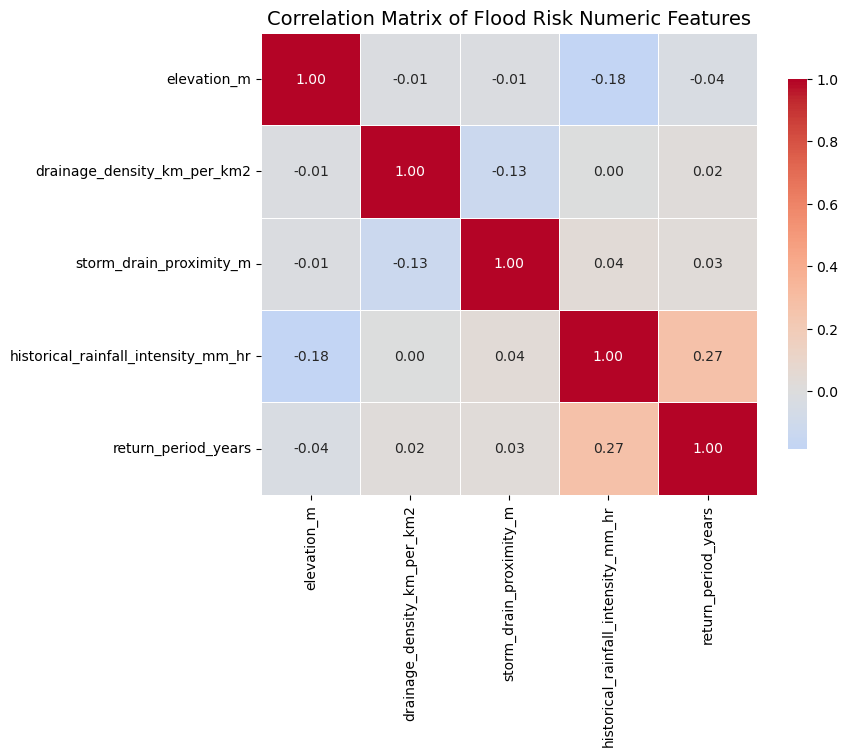

In [19]:
# Create correlation matrix heatmap
fig_heatmap, ax = plt.subplots(figsize=(8,6))
corr = df_num.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)

ax.set_title("Correlation Matrix of Flood Risk Numeric Features", fontsize=14)
plt.show()

### Correlation Matrix Observation

<b>Overall strength of relationships</b> 
- Most coefficients are weak (< |0.2|), meaning the numeric variables are largely independent.
- This independence is useful for later clustering because it reduces redundancy between features.

<b>Elevation vs. Rainfall Intensity (-0.18)</b>
- A small negative correlation: lower elevation areas are somewhat more likely to experience higher rainfall intensities.
- While weak, this aligns with the intuition that low-lying areas may face greater exposure to intense events.

<b>Drainage Density vs. Storm Drain Proximity (-0.13)</b>
- Weak negative relationship: in areas with denser drainage networks, the distance to the nearest drain tends to be shorter.
- This supports the idea that urban infrastructure density reduces service gaps.

<b>Rainfall Intensity vs. Return Period (0.27)</b>
- The strongest relationship in the matrix: higher rainfall intensities are associated with longer return periods (rarer, more extreme events).
- This provides evidence that the dataset reflects hydrologic expectations.

<b>Other pairs (near 0)</b>
- Many variables (e.g., elevation vs. drainage density, proximity vs. return period) show near-zero correlations.
- This indicates that those dimensions capture different aspects of flood risk and should be explored separately.

<b>The clearest signal is the link between intense rainfall and rare events, while infrastructure and elevation effects will be better examined through categorical comparisons and spatial analysis.</b>

### Export Heatmap

In [30]:
out_dir = "/Users/charlottelin/Documents/Achievement 6 Urban Flood Risk/04 Analysis/Visualizations"
os.makedirs(out_dir, exist_ok=True)

fig_heatmap.savefig(f"{out_dir}/heatmap.png", dpi=300, bbox_inches="tight")

## Scatterplots

### From the heatmap, the strongest correlation was "Rainfall intensity vs. Return period" (r ≈ 0.27, positive). And a weaker but still logical one was "Drainage density vs. Storm drain proximity" (r ≈ -0.13, negative). I will create these two scatterplots.

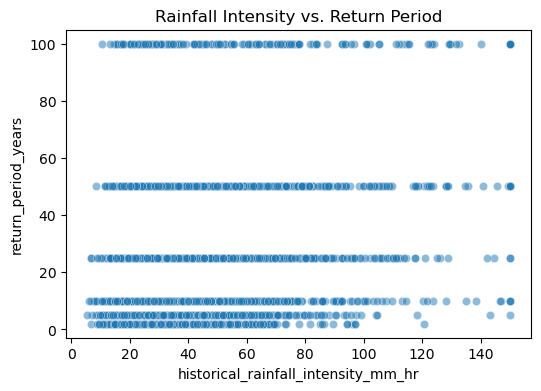

In [21]:
# Scatterplot 1: Rainfall Intensity vs. Return Period
fig_scatter1, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x="historical_rainfall_intensity_mm_hr", 
                y="return_period_years", alpha=0.5, ax=ax)
ax.set_title("Rainfall Intensity vs. Return Period")
plt.show()

#### A positive association as higher rainfall intensities are more common at longer return periods.
- The relationship is step-like because return period is discrete (2, 5, 10, 25, 50, 100 years).
- Outliers at high intensities (>100 mm/hr) highlight extreme cases that dominate the upper return periods.
- This aligns with hydrologic expectations as rarer events are characterized by more intense rainfall.

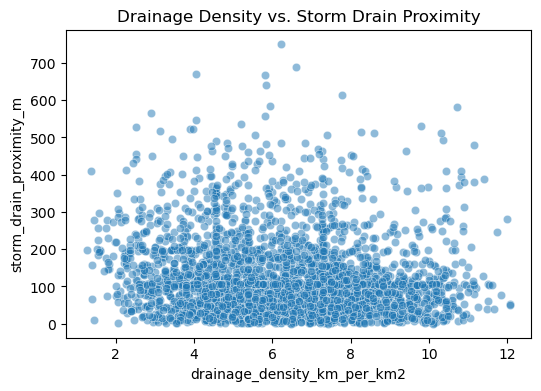

In [22]:
# Scatterplot 2: Drainage Density vs. Storm Drain Proximity
fig_scatter2, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x="drainage_density_km_per_km2", 
                y="storm_drain_proximity_m", alpha=0.5, ax=ax)
ax.set_title("Drainage Density vs. Storm Drain Proximity")
plt.show()

#### The relationship is weakly negative: higher drainage densities are generally associated with shorter distances to the nearest storm drain.
- However, the points are widely dispersed, indicating substantial variability even within similar density levels.
- This suggests that while dense networks help reduce proximity on average, local infrastructure layouts strongly influence actual distances.

In [23]:
# Export scatterplots
fig_scatter1.savefig(f"{out_dir}/scatter_rainfall_returnperiod.png", dpi=300, bbox_inches="tight")
fig_scatter2.savefig(f"{out_dir}/scatter_drainage_proximity.png", dpi=300, bbox_inches="tight")

## Pair Plot

### This is the pair plot of the entire dataset that contains numeric values

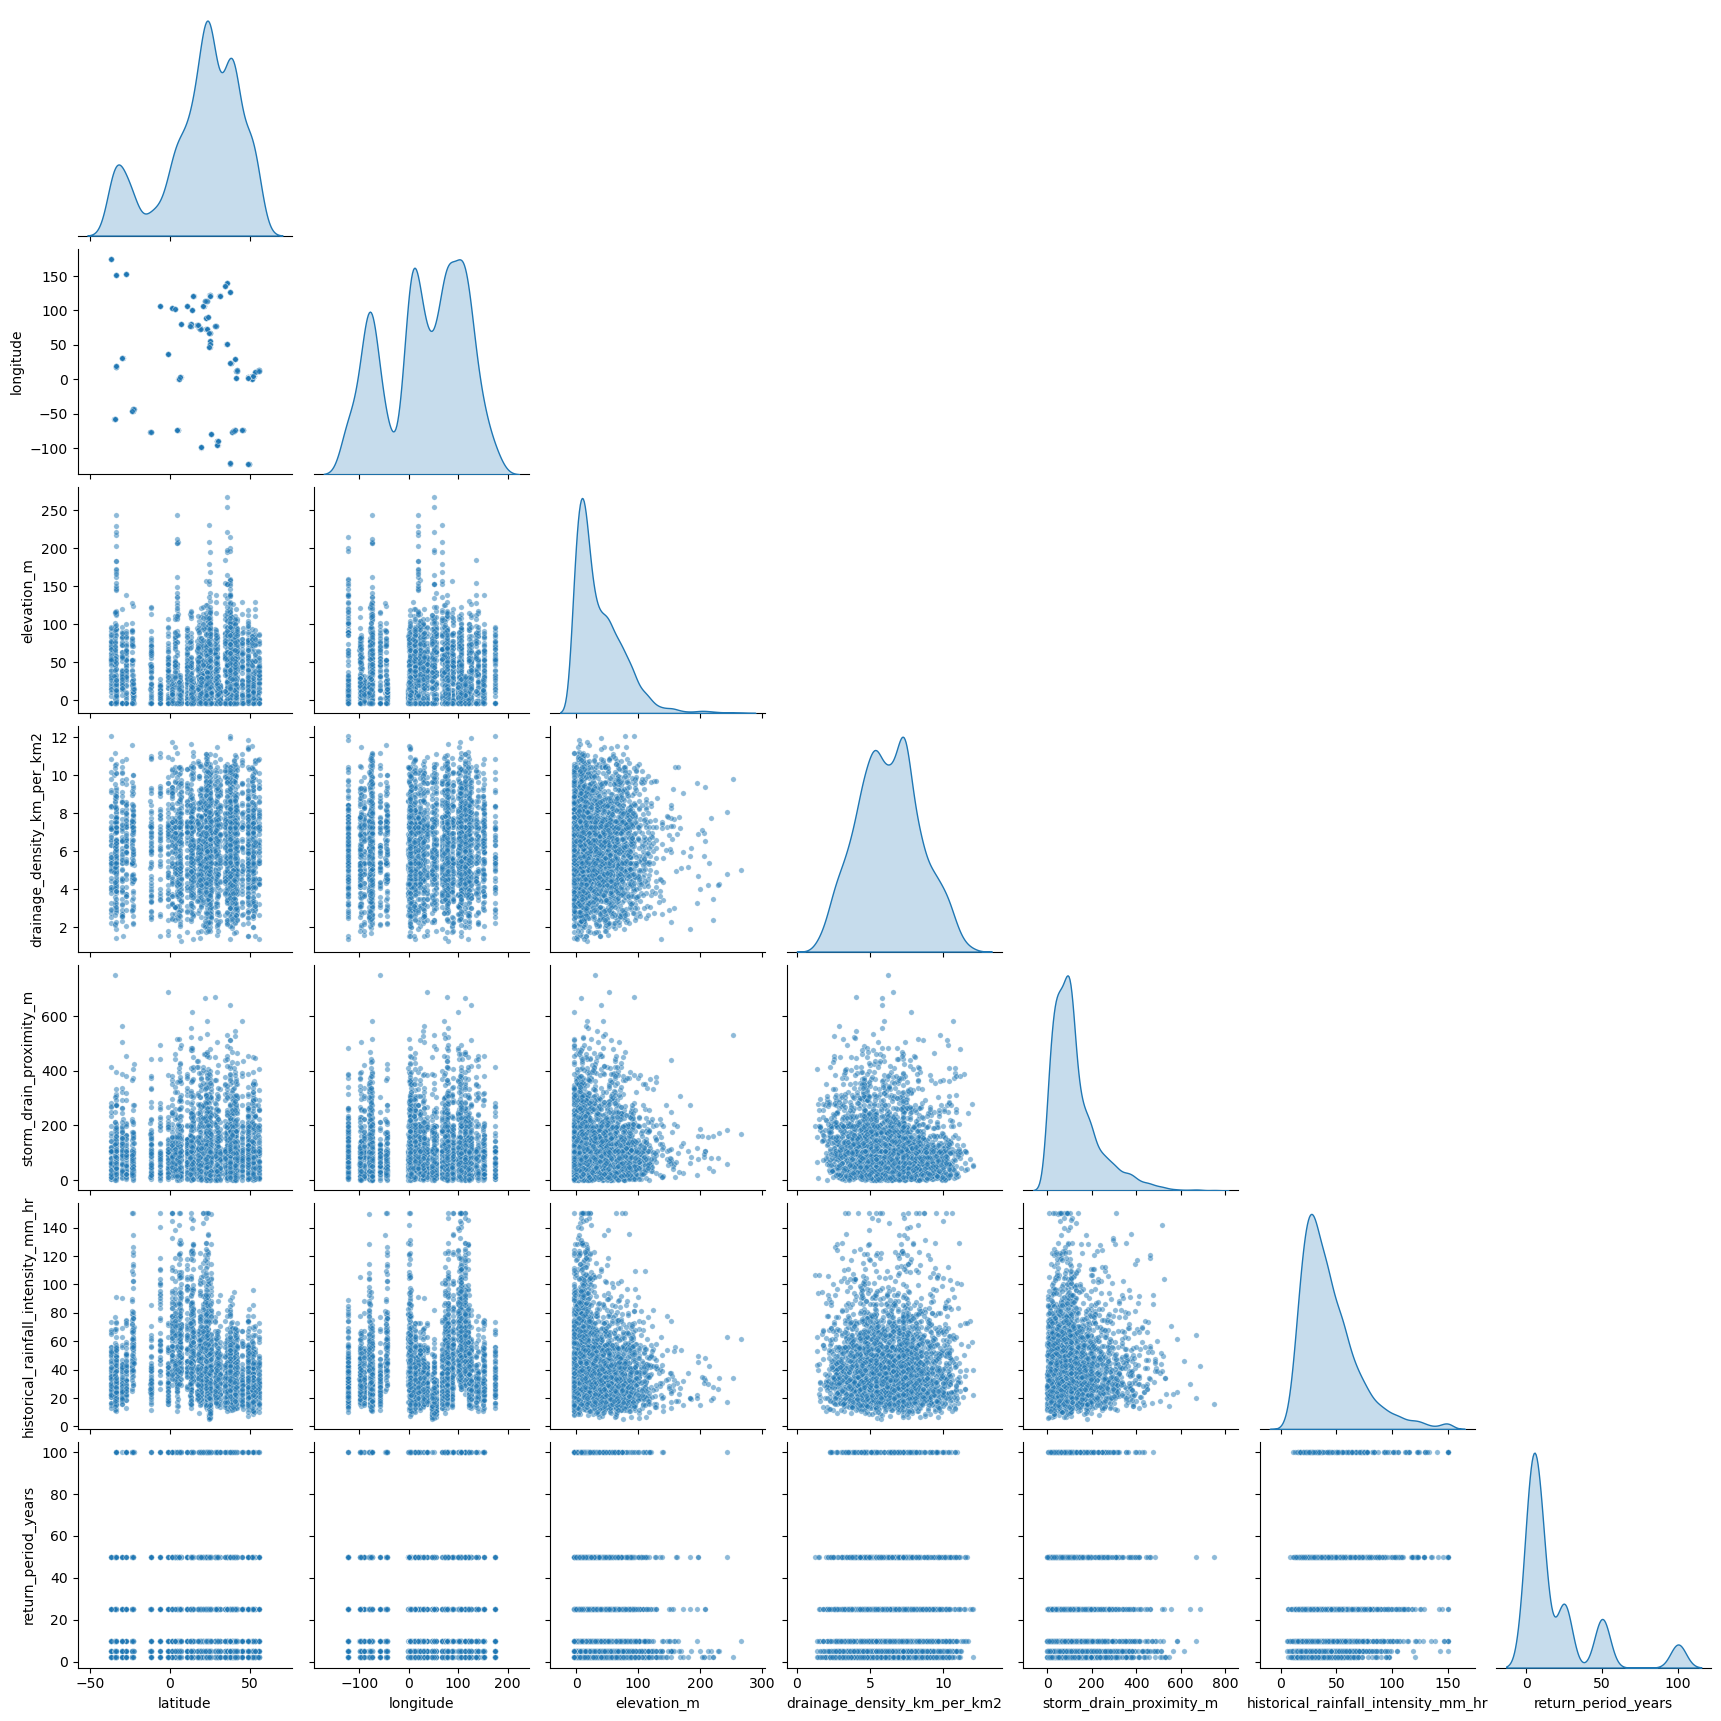

In [31]:
df_num_all = df.select_dtypes(include=['float64', 'int64'])

# Pair plot of all numeric variables
pairplot = sns.pairplot(
    df_num_all, 
    diag_kind="kde", 
    corner=True,
    plot_kws={'alpha':0.5, 's':15}
)

#### Pair Plot Observations

<b>Latitude & Longitude</b>
- Suitable for mapping in Tableau, but not useful for correlation or clustering analysis.

<b>Elevation (m)</b>
- Right-skewed distribution: most values are below 50m, but a long tail extends to ~267m.
- Scatterplots with latitude/longitude confirm city-level differences (e.g., coastal vs. inland sites).
- Worth exploring further against `low_lying` risk labels and spatial clustering.

<b>Drainage Density (km/km²)</b>
- Roughly bell-shaped, centered around 6 km/km², with some variation by geography.
- Negative association with storm drain proximity is visible (denser networks = closer drains).

<b>Storm Drain Proximity (m)</b>
- Highly skewed: most values under 200m, but long tails extend to >700m.
- Outliers are clearly visible and may represent unmapped or sparse drainage segments.
- **Critical for identifying sparse_drainage segments.**

<b>Historical Rainfall Intensity (mm/hr)</b>
- Right-skewed, clustered around 20–60 mm/hr with rare extremes >100 mm/hr.
- Scatter with return period shows step-like bands — higher intensities at longer return periods.
- **Strong candidate for comparison with extreme_rain_history labels.**

<b>Return Period (years)</b>
- Discrete distribution with six bands (2, 5, 10, 25, 50, 100).
- Not continuous — best handled as a categorical grouping variable in boxplots.
- Useful for grouping rainfall intensities and event-tagged segments.

<b>Variables to Explore Further</b>
- Storm Drain Proximity – extreme skew and long-tailed outliers suggest it’s a key differentiator for sparse infrastructure.
- Rainfall Intensity – outliers align with rare/major events; must be linked to risk labels and return periods.
- Elevation – low-lying cluster confirms importance for validating flood-prone segments.
- Return Period – categorical nature calls for boxplots/grouped analyses rather than correlations.

In [33]:
# Export Pair Plot
out_dir = "/Users/charlottelin/Documents/Achievement 6 Urban Flood Risk/04 Analysis/Visualizations"
pairplot.fig.savefig(f"{out_dir}/pairplot_all.png", dpi=300, bbox_inches="tight")

## Categorical Plots

### Rainfall Density by Rainfall Source

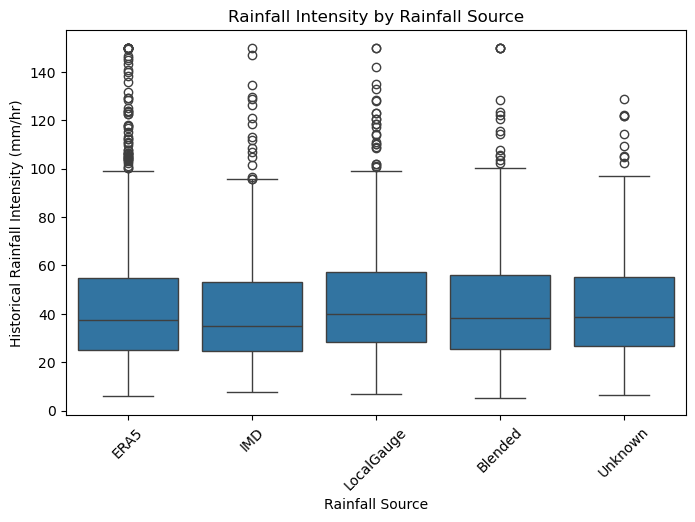

In [34]:
fig_cat1, ax = plt.subplots(figsize=(8,5))
sns.boxplot(data=df, x="rainfall_source", y="historical_rainfall_intensity_mm_hr", ax=ax)
ax.set_title("Rainfall Intensity by Rainfall Source")
ax.set_xlabel("Rainfall Source"); ax.set_ylabel("Historical Rainfall Intensity (mm/hr)")
plt.xticks(rotation=45)
plt.show()

#### `ERA5` exhibits a higher median and wider upper tail of `historical_rainfall_intensity_mm_hr` than `LocalGauge`, `Blended`, or `IMD`.

### Storm Drain Promiximity by Storm Drain Type

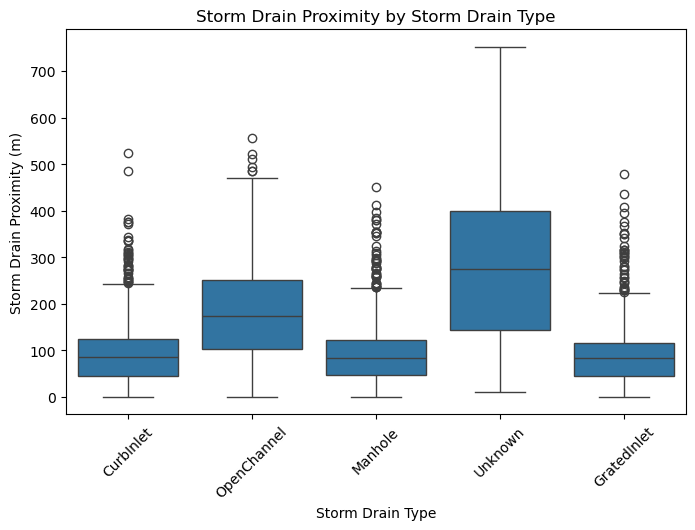

In [35]:
fig_cat2, ax = plt.subplots(figsize=(8,5))
sns.boxplot(data=df, x="storm_drain_type", y="storm_drain_proximity_m", ax=ax)
ax.set_title("Storm Drain Proximity by Storm Drain Type")
ax.set_xlabel("Storm Drain Type"); ax.set_ylabel("Storm Drain Proximity (m)")
plt.xticks(rotation=45)
plt.show()

#### `OpenChannel` has a higher median and broader spread of `storm_drain_proximity_m`. `CurbInlet`, `Manhole`, and `GratedInlet` are closer on average. This aligns with urban drainage design as many distributed inlets/manholes shorten distances. Open channels are less frequent and farther apart. **`storm_drain_type`** is a strong categorical driver of proximity and should be included in infrastructure comparisons and any clustering feature set.

### Rainfall Intensity by Return Period, grouped by Extreme Rain History

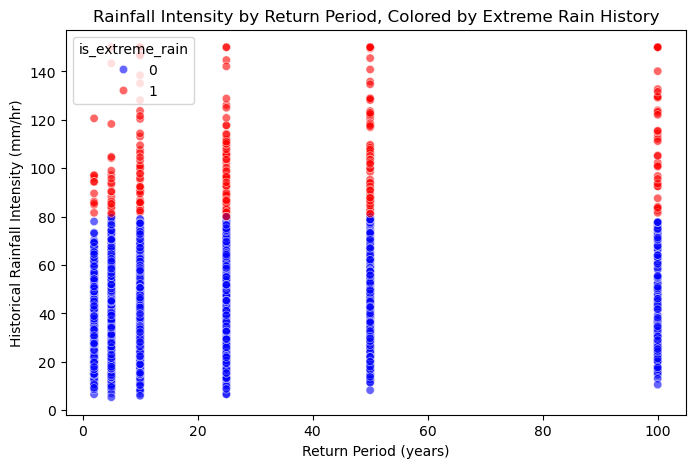

In [36]:
# Create a binary flag for extreme rain history
df["is_extreme_rain"] = df["risk_labels"].str.contains(r"\bextreme_rain_history\b", na=False).astype(int)

fig_cat_hue, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(
    data=df, 
    x="return_period_years", 
    y="historical_rainfall_intensity_mm_hr",
    hue="is_extreme_rain",  # color by label
    palette={0: "blue", 1: "red"},
    alpha=0.6
)
ax.set_title("Rainfall Intensity by Return Period, Colored by Extreme Rain History")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Historical Rainfall Intensity (mm/hr)")
plt.show()


#### At each return period category (2, 5, 10, 25, 50, 100 years), there’s a range of rainfall intensities. Points flagged with the `extreme_rain_history` label (red) consistently cluster at the higher end of intensities compared to unflagged points (blue). The step-like appearance reflects the discrete nature of return periods, but within each band the color split highlights a meaningful difference. The extreme_rain_history label corresponds to higher-intensity rainfall events. This confirms the label is semantically valid and can be used in further analysis as a risk indicator.

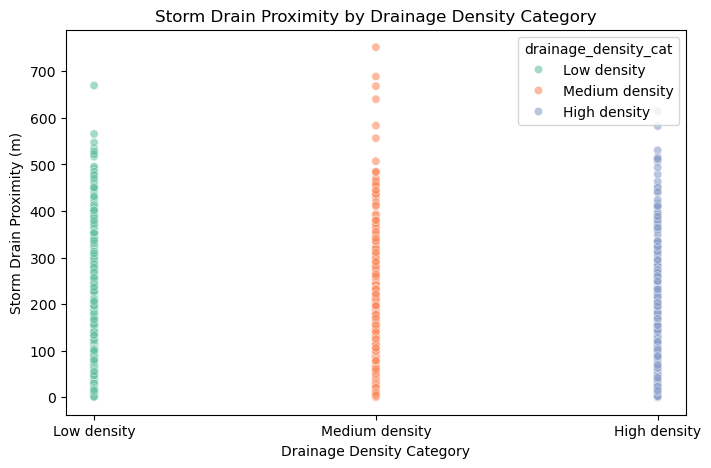

In [37]:
df["drainage_density_cat"] = pd.qcut(df["drainage_density_km_per_km2"], q=3, labels=["Low density","Medium density","High density"])

fig_cat_hue2, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(
    data=df,
    x="drainage_density_cat",
    y="storm_drain_proximity_m",
    hue="drainage_density_cat",
    palette="Set2",
    alpha=0.6
)
ax.set_title("Storm Drain Proximity by Drainage Density Category")
ax.set_xlabel("Drainage Density Category")
ax.set_ylabel("Storm Drain Proximity (m)")
plt.show()


#### Across categories, storm drain proximity is highly variable, with a wide spread from near-zero to >700m. Segments in the high-density category generally have lower proximities (closer to drains), while low-density areas tend to show larger proximities. This means higher drainage density is associated with shorter average distances to storm drains, supporting the logic that denser networks reduce service gaps. **This validates using drainage density as a structural measure of infrastructure adequacy, with implications for identifying sparse-drainage hotspots.**

In [39]:
# Export categorical plots
fig_cat1.savefig(f"{out_dir}/cat_rainfall_intensity_by_source.png", dpi=300, bbox_inches="tight")
fig_cat2.savefig(f"{out_dir}/cat_proximity_by_drain_type.png", dpi=300, bbox_inches="tight")
fig_cat_hue.savefig(f"{out_dir}/scatter_rainfall_returnperiod_extremerain.png", dpi=300, bbox_inches="tight")
fig_cat_hue2.savefig(f"{out_dir}/scatter_proximity_by_drainagedensity.png", dpi=300, bbox_inches="tight")

### Drainage Density by Land Use

/var/folders/t0/dyr0vh9d10q4v8pztlwjgtkh0000gn/T/ipykernel_7841/640910267.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


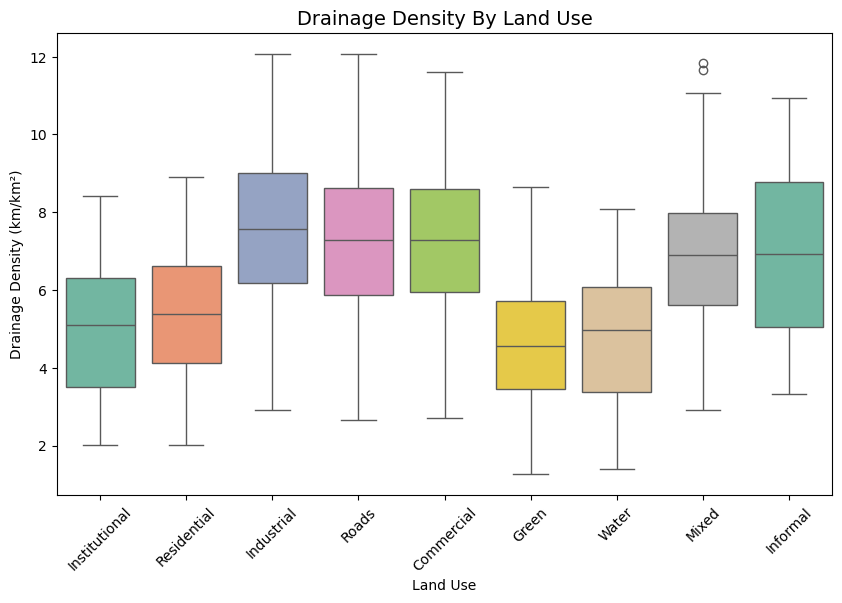

In [42]:
fig_landuse, ax = plt.subplots(figsize=(10,6))
sns.boxplot(
    data=df,
    x="land_use",
    y="drainage_density_km_per_km2",
    ax=ax,
    palette="Set2"
)

# Titles and labels
ax.set_title("Drainage Density By Land Use", fontsize=14)
ax.set_xlabel("Land Use")
ax.set_ylabel("Drainage Density (km/km²)")

plt.xticks(rotation=45)
plt.show()

In [41]:
# Export 
fig_landuse.savefig(f"{out_dir}/boxplot_drainage_density_by_land_use.png", dpi=300, bbox_inches="tight")

#### `Industrial`, `Commercial`, and `Roads` have higher median drainage density values, which indicates denser stormwater infrastructure in built-up areas. `Residential` and `Institutional` land uses show moderate densities, consistent with distributed but less intensive drainage networks. `Green` and `Water` categories have lower medians and wider variability, which suggests sparse or naturally drained areas. `Mixed` and `Informal` areas show more variability, with some segments exhibiting both very low and very high densities with uneven infrastructure coverage. **Drainage density is closely linked to land use**. This confirms land use as a meaningful driver of infrastructure adequacy, making it a useful variable for stratified risk analysis and clustering.